In [3]:
#import all necessary libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import matplotlib
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model

from scipy import stats
import seaborn as sns
sns.set_style('whitegrid')

from datetime import datetime
import yfinance as yf

from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.models import Sequential, load_model
import tensorflow.keras.backend as k
from tensorflow.keras.losses import MeanAbsoluteError
#from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [4]:
# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

# Fetch the stock data
company_data = {}

for stock in tech_list:
    company_data[stock] = yf.download(stock, start=start, end=end,actions=False)

# Add company name to each DataFrame and concatenate into a single DataFrame
company_list = [company_data[stock] for stock in tech_list]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for df, name in zip(company_list, company_name):
    df["company_name"] = name

df = pd.concat(company_list, axis=0)
print(df.tail(10))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-08-09  166.399994  168.550003  165.850006  166.940002  166.940002   
2024-08-12  168.139999  168.550003  166.110001  166.800003  166.800003   
2024-08-13  167.809998  171.039993  167.100006  170.229996  170.229996   
2024-08-14  172.110001  172.279999  168.860001  170.100006  170.100006   
2024-08-15  174.860001  177.910004  173.990005  177.589996  177.589996   
2024-08-16  177.039993  178.339996  176.259995  177.059998  177.059998   
2024-08-19  177.639999  178.300003  176.160004  178.220001  178.220001   
2024-08-20  177.919998  179.009995  177.429993  178.880005  178.880005   
2024-08-21  179.919998  182.389999  178.889999  180.110001  180.110001   
2024-08-22  181.380005  181.470001  175.679993  176.130005  176.130005   

              Volume company_name  
Date                               
2024-08-09  36401000       AMAZON  
202

In [5]:
# Example DataFrame
data = df

# Ensure the data is numeric
numeric_data = data.select_dtypes(include=[np.number])

# Calculate z-scores
z_scores = stats.zscore(numeric_data)

# Identify outliers
outliers = (np.abs(z_scores) > 3)
            
# Print outliers
print("Outlier rows (True indicates an outlier):")
print(outliers)

Outlier rows (True indicates an outlier):
             Open   High    Low  Close  Adj Close  Volume
Date                                                     
2019-08-23  False  False  False  False      False    True
2019-08-26  False  False  False  False      False   False
2019-08-27  False  False  False  False      False   False
2019-08-28  False  False  False  False      False   False
2019-08-29  False  False  False  False      False   False
...           ...    ...    ...    ...        ...     ...
2024-08-16  False  False  False  False      False   False
2024-08-19  False  False  False  False      False   False
2024-08-20  False  False  False  False      False   False
2024-08-21  False  False  False  False      False   False
2024-08-22  False  False  False  False      False   False

[5032 rows x 6 columns]


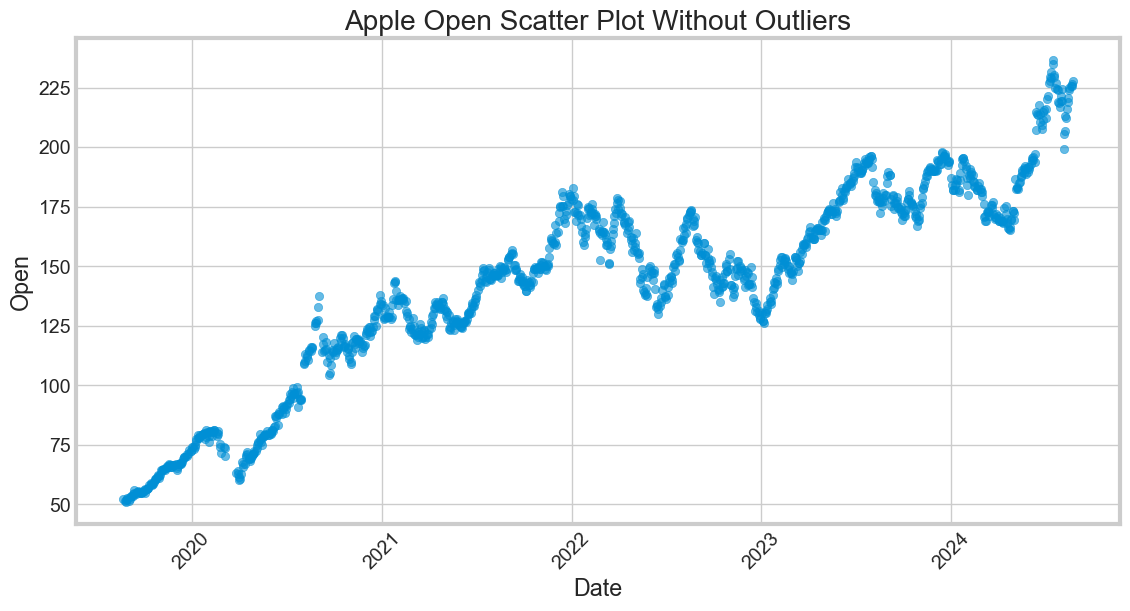

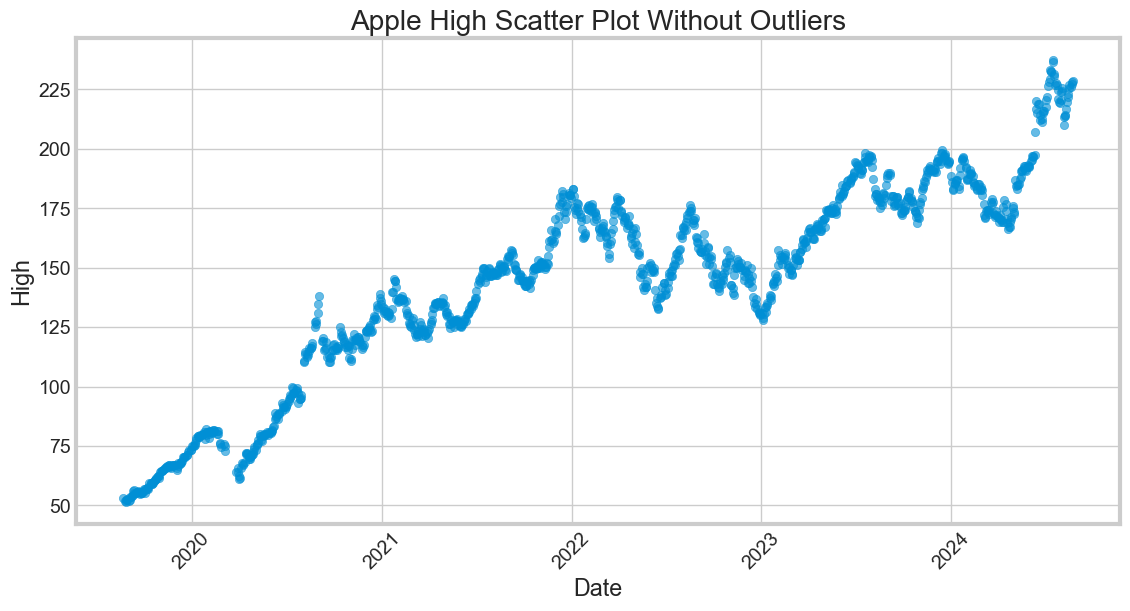

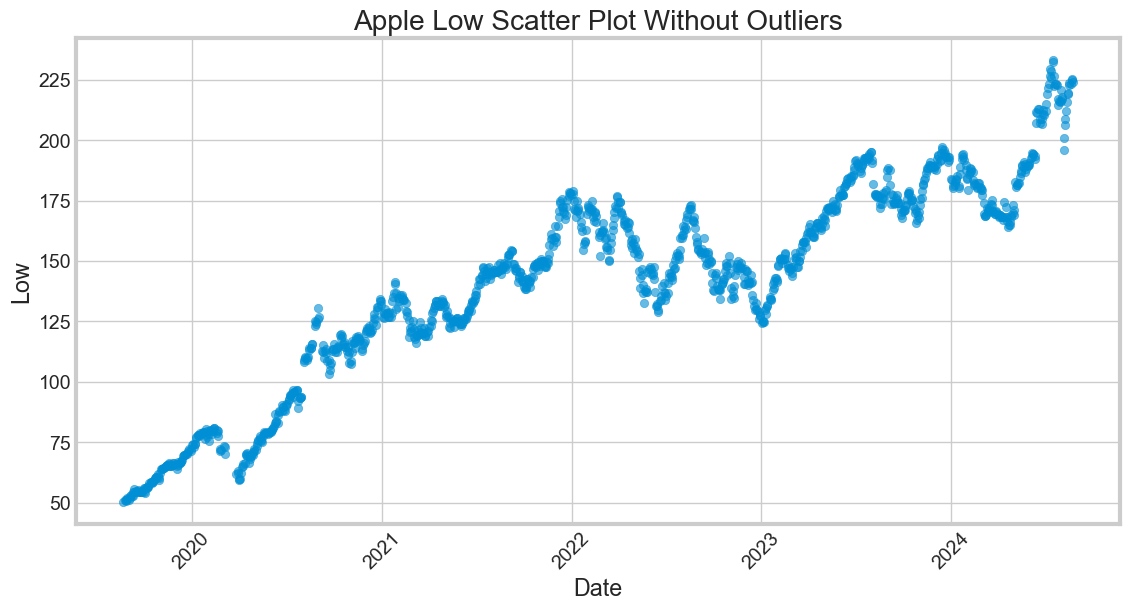

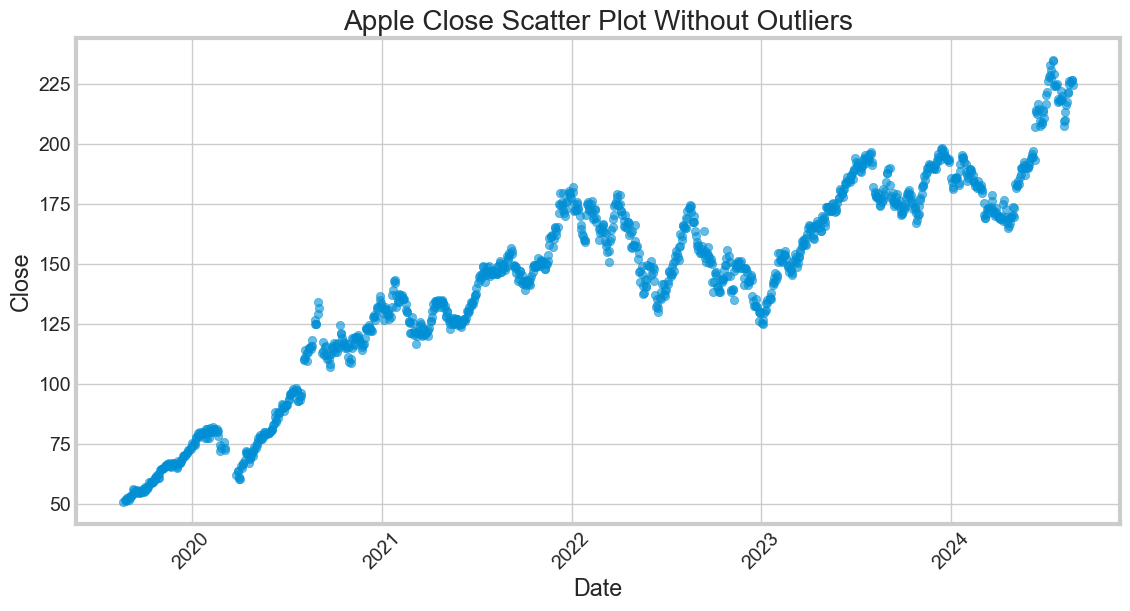

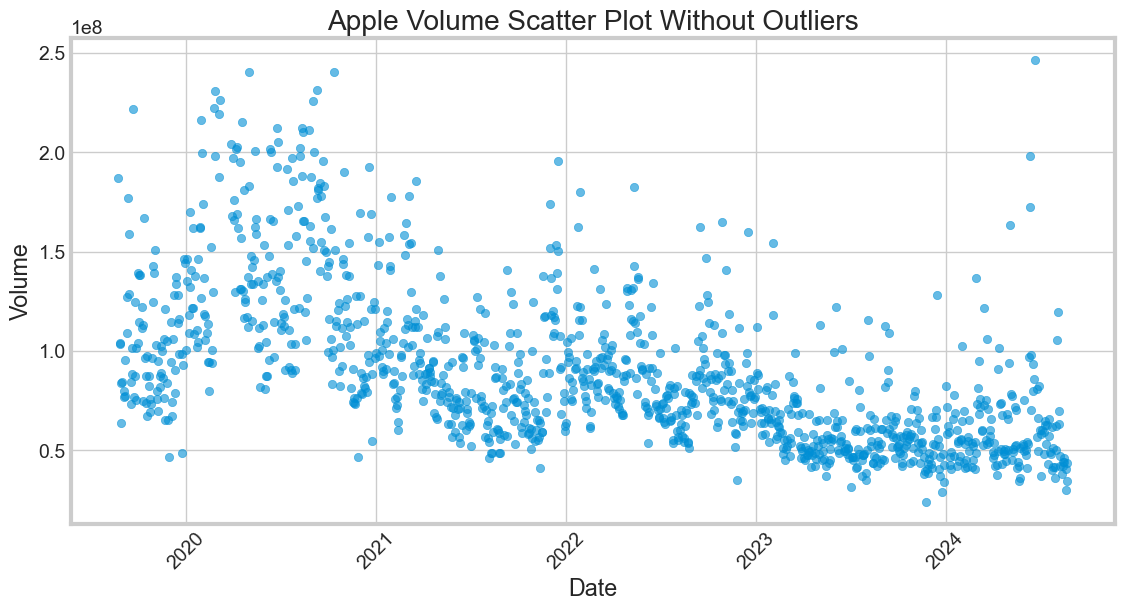

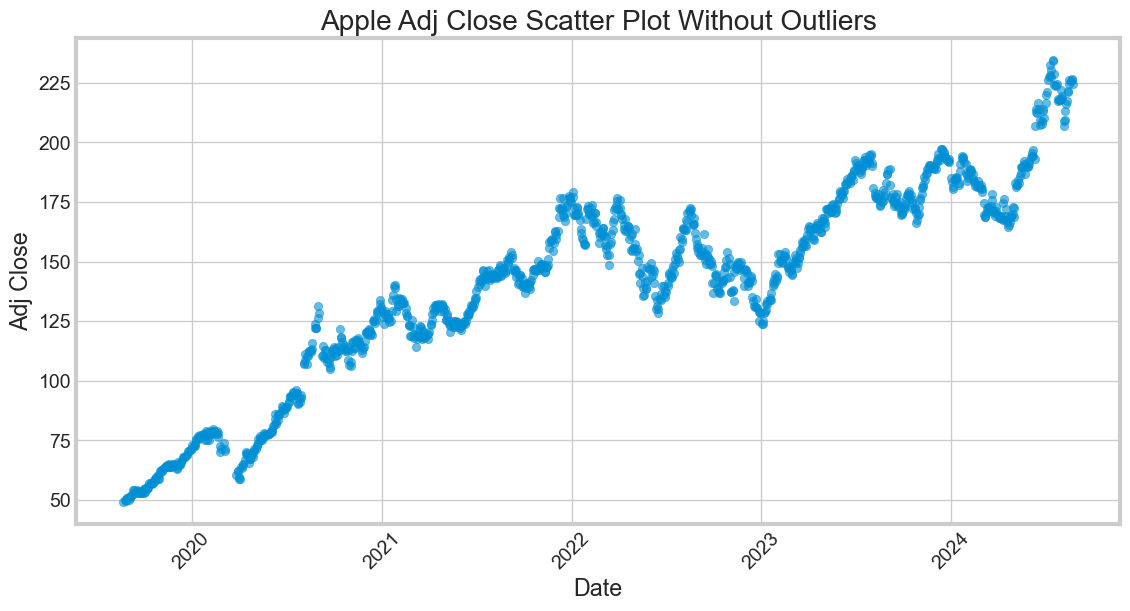

In [6]:
data = company_data['AAPL']
columns_to_keep = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
data = data[columns_to_keep]

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

#handle outliers with a method
def remove_outliers(df):
    z_scores = stats.zscore(df.select_dtypes(include=[np.number]))
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    return df[filtered_entries]

#use the method for the company
data_cleaned=remove_outliers(data)

numerical_columns = data_cleaned.select_dtypes(include=[np.number]).columns

#show the results
for column in numerical_columns:
    plt.figure(figsize=(12, 6))
    plt.scatter(data_cleaned.index, data_cleaned[column], alpha=0.6)
    plt.title(f'Apple {column} Scatter Plot Without Outliers')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.xticks(rotation=45)
    plt.show()
#print(data_cleaned.tail(10))

In [7]:
#Set Target Variableth
#Can filter close either or way
#output_var = pd.DataFrame(data_cleaned, columns=['Close']) 
Target = data_cleaned.filter(['Close'])

#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']
Target.tail

<bound method NDFrame.tail of                  Close
Date                  
2019-08-23   50.660000
2019-08-26   51.622501
2019-08-27   51.040001
2019-08-28   51.382500
2019-08-29   52.252499
...                ...
2024-08-16  226.050003
2024-08-19  225.889999
2024-08-20  226.509995
2024-08-21  226.399994
2024-08-22  224.529999

[1230 rows x 1 columns]>

In [8]:
#Scaling
scaler = MinMaxScaler(feature_range= (0,1))
feature_transform = scaler.fit_transform(data_cleaned[features])
feature_transform = pd.DataFrame(columns = features, data = feature_transform, index = data_cleaned.index)
feature_transform.head()

,Open,High,Low,Volume
Date,,,,
2019-08-23,0.007185,0.008517,0.000000,0.734008
2019-08-26,0.002373,0.001978,0.005551,0.360323
2019-08-27,0.005069,0.003808,0.003459,0.357259
2019-08-28,0.000000,0.000000,0.003172,0.178560
2019-08-29,0.005931,0.004844,0.007739,0.269429


In [9]:
#Splitting to Training, Testing and Validation set
timesplit = TimeSeriesSplit(n_splits=10)

for train_index, test_index in timesplit.split(feature_transform):
    # Define the training and testing sets
    X_train = feature_transform[:len(train_index)]
    X_test = feature_transform[len(train_index): (len(train_index) + len(test_index))]
    y_train = Target[:len(train_index)].values.ravel()
    y_test =Target[len(train_index): (len(train_index) + len(test_index))].values.ravel()
    
     # Further split the training set into training and validation sets
    
    split_ratio = 0.8 # Example: 80% of the training data for training, 20% for validation
    split_point = int(len(X_train) * split_ratio)
    
    X_train_temp = X_train[:split_point]
    X_val = X_train[split_point:]
    
    y_train_final = y_train[:split_point]
    y_val = y_train[split_point:]    
    # The Data is now split into training, validation and testing sets  
    print("Shape of feature_transform:", feature_transform.shape)
    
print("Shape after split - X_train:", X_train.shape)
print("Shape after split - X_val and X_train_temp:", X_val.shape, X_train_temp.shape)
print("Shape after split - X_test:", X_test.shape)

Shape of feature_transform: (1230, 4)
Shape of feature_transform: (1230, 4)
Shape of feature_transform: (1230, 4)
Shape of feature_transform: (1230, 4)
Shape of feature_transform: (1230, 4)
Shape of feature_transform: (1230, 4)
Shape of feature_transform: (1230, 4)
Shape of feature_transform: (1230, 4)
Shape of feature_transform: (1230, 4)
Shape of feature_transform: (1230, 4)
Shape after split - X_train: (1119, 4)
Shape after split - X_val and X_train_temp: (224, 4) (895, 4)
Shape after split - X_test: (111, 4)


In [10]:
# Process the data for LSTM, turn them into np arrays
X_train_temp = np.array(X_train_temp)
X_val = np.array(X_val)
X_test = np.array(X_test)


# Reshape them into 3D format
X_train_final = X_train_temp.reshape((X_train_temp.shape[0], 1, X_train_temp.shape[1]))
X_val_final = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_final = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print('Final X training set: ', X_train_final.shape)
print("Final X validation set shape: ", X_val_final.shape)
print("Final X test set shape: ", X_test_final.shape)

Final X training set:  (895, 1, 4)
Final X validation set shape:  (224, 1, 4)
Final X test set shape:  (111, 1, 4)


In [11]:
model = Sequential()
model.add(Input(shape=(1,X_train_final.shape[2])))
model.add(LSTM(128, return_sequences = True, activation = 'relu'))
model.add(Dropout(0.2))  # Dropout to prevent overfitting

model.add(LSTM(64, return_sequences = True, activation = 'relu'))
model.add(Dropout(0.2))

model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(50, activation='relu'))  # Additional Dense layer
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(Dense(25))

model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='MeanAbsoluteError',metrics=['MeanAbsoluteError'])
# Ensure model is built
model.build((None, 1, X_train_final.shape[2]))

early_stopping = EarlyStopping(monitor='val_MeanAbsoluteError', patience=10, restore_best_weights=True,mode='min')

plot_model(model, show_shapes=True, show_layer_names=True)

history =model.fit(X_train_final, y_train_final, batch_size = 1, epochs =30, validation_data=(X_val_final, y_val),callbacks=[early_stopping],verbose=1)

Epoch 1/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - MeanAbsoluteError: 56.3976 - loss: 56.3976 - val_MeanAbsoluteError: 20.0388 - val_loss: 20.0388
Epoch 2/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - MeanAbsoluteError: 18.2193 - loss: 18.2193 - val_MeanAbsoluteError: 33.6968 - val_loss: 33.6968
Epoch 3/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - MeanAbsoluteError: 17.7947 - loss: 17.7947 - val_MeanAbsoluteError: 3.4129 - val_loss: 3.4129
Epoch 4/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - MeanAbsoluteError: 15.2412 - loss: 15.2412 - val_MeanAbsoluteError: 4.2797 - val_loss: 4.2797
Epoch 5/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - MeanAbsoluteError: 14.5587 - loss: 14.5587 - val_MeanAbsoluteError: 5.2749 - val_loss: 5.2749
Epoch 6/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - MeanAbsoluteError: 12.6029 - loss: 12.6029 - val_MeanAbsoluteError: 2.3258 - val_loss: 2.3258
Epoch 7/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - MeanAbsoluteError: 13.2495 - loss: 13.2495 - val_MeanA

In [12]:
y_pred = model.predict(X_test_final)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


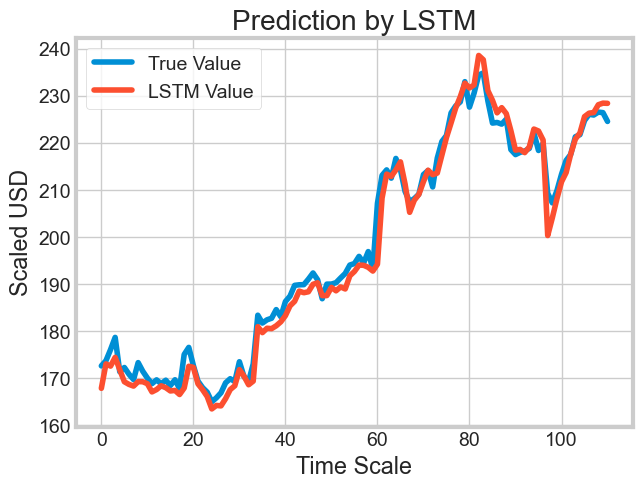

In [13]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

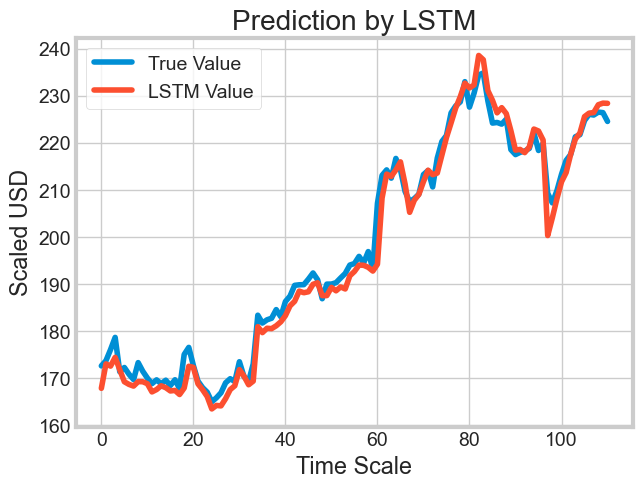

In [14]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()


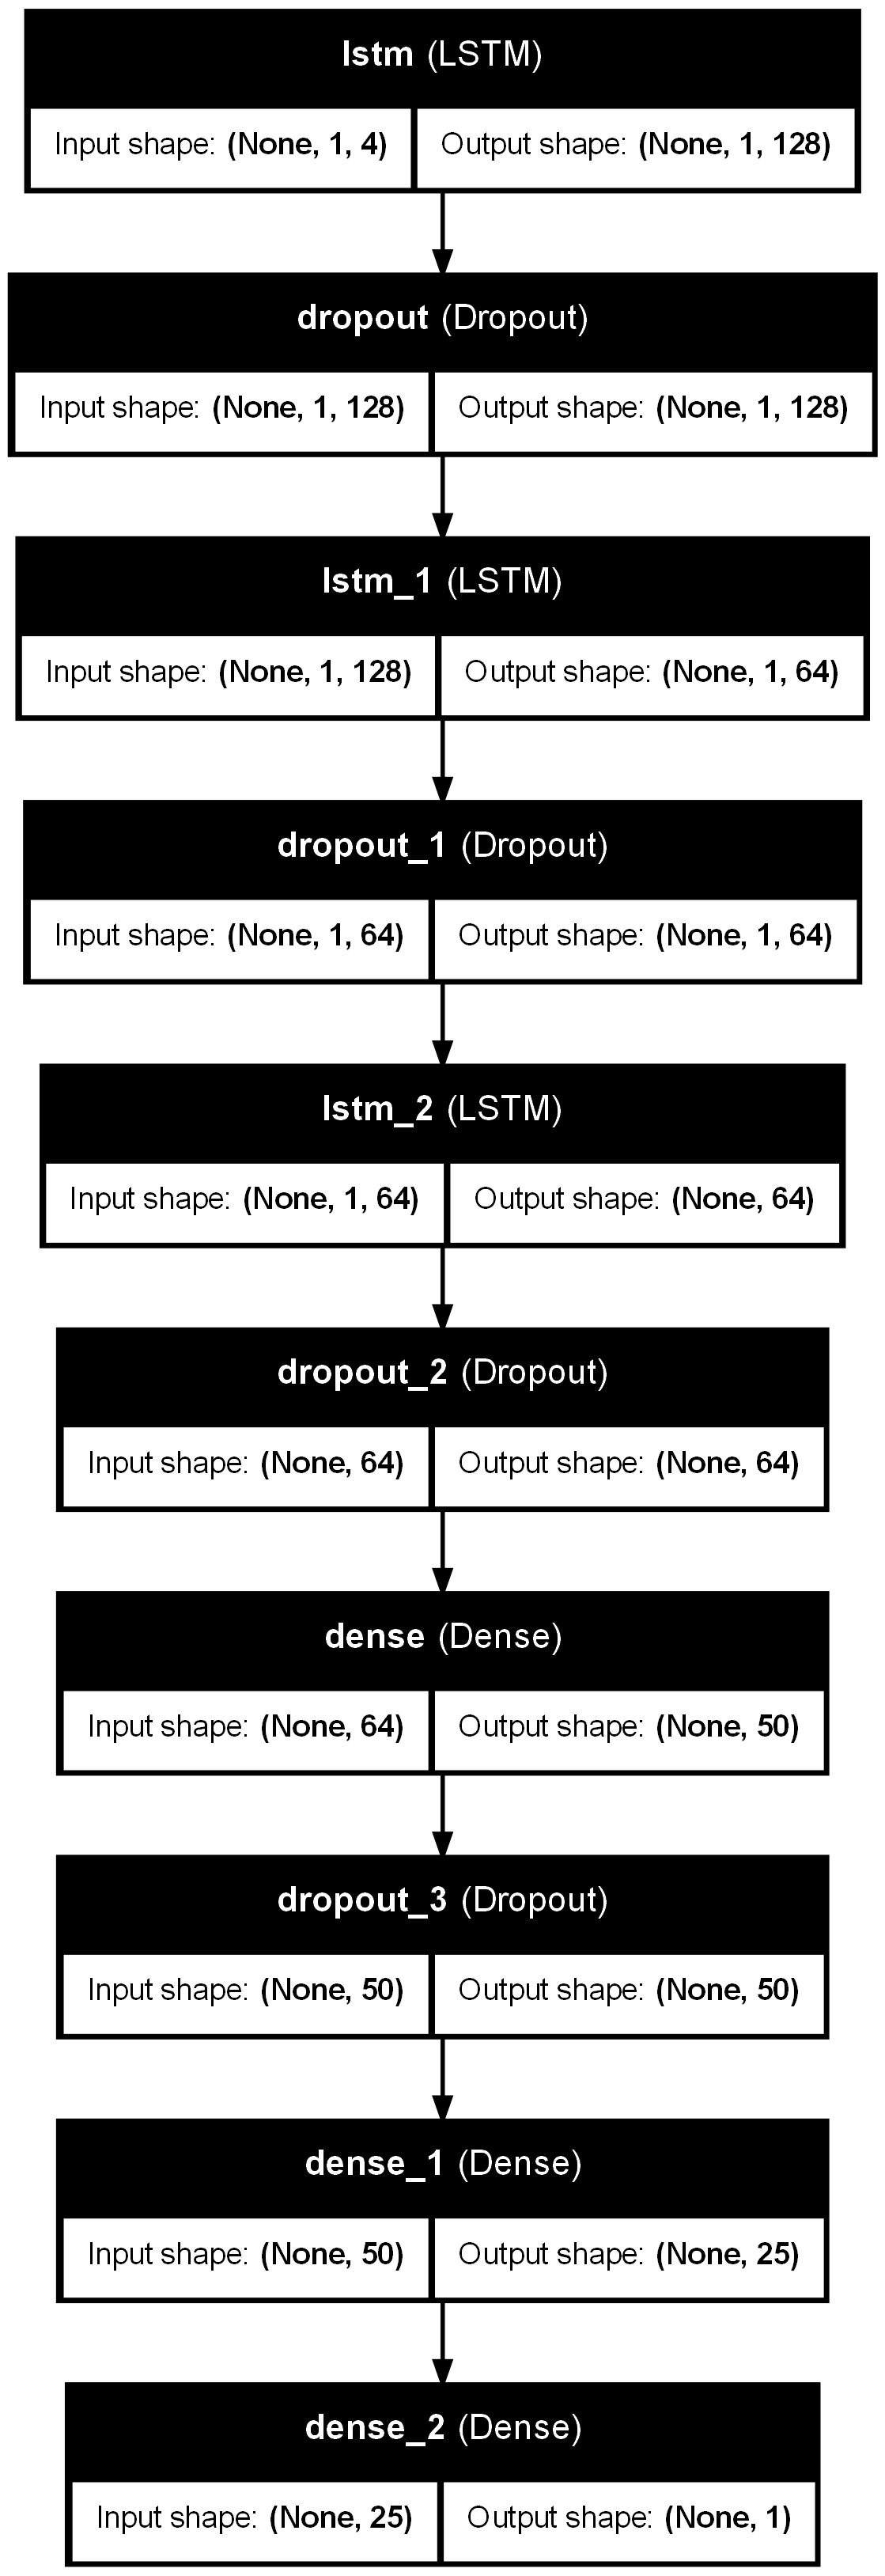

In [15]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [40]:

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [57]:
stock_symbol = 'AAPL'
data = yf.download(stock_symbol, period='5y', interval='1d')

# Feature Engineering
data['Daily Return'] = data['Close'].pct_change()
data['Moving Average'] = data['Close'].rolling(window=20).mean()
data.dropna(inplace=True)

# Define features and target
features = ['Daily Return', 'Moving Average']
data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)  # 1: Buy, 0: Sell

# Split data into training and testing sets
X = data[features]
y = data['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predict on the test set and evaluate
y_pred = model.predict(X_test_scaled)

# Preparing to predict for the future
# Use the most recent data to generate features for future prediction
recent_data = data[-20:].copy()  # Make sure to copy to avoid warnings

# Generate features for prediction
recent_data['Daily Return'] = recent_data['Close'].pct_change()
recent_data['Moving Average'] = recent_data['Close'].rolling(window=20).mean()
recent_data.dropna(inplace=True)

# Display recent data and calculated features
print("Most Recent Data:\n", recent_data.tail(10))

# Use only the most recent row for future prediction, keeping it in DataFrame format
latest_features = recent_data[features].iloc[-1:]

# Show the feature values before scaling
print("\nFeature Values for Prediction (Unscaled):\n", latest_features)

# Predict using the trained model
latest_features_scaled = scaler.transform(latest_features)
future_prediction = model.predict(latest_features_scaled)

# Interpret the prediction
action = "Buy" if future_prediction[0] == 1 else "Sell"

# Show scaled feature values and prediction
print("\nFeature Values for Prediction (Scaled):\n", latest_features_scaled)
print("Future prediction for the next day: ", action)

[*********************100%%**********************]  1 of 1 completed

Most Recent Data:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-08-22  227.789993  228.339996  223.899994  224.529999  224.529999   

              Volume  Daily Return  Moving Average  Target  
Date                                                        
2024-08-22  43665900      -0.00826      219.289501       0  

Feature Values for Prediction (Unscaled):
             Daily Return  Moving Average
Date                                    
2024-08-22      -0.00826      219.289501

Feature Values for Prediction (Scaled):
 [[-0.45531444  2.4397383 ]]
Future prediction for the next day:  Sell
